Data
- https://www.cs.utexas.edu/~rofuyu/papers/tr-mf-nips.pdf
- https://files.stlouisfed.org/files/htdocs/conferences/2014-nber-nsf/docs/papers/Nicholson,%20Will.pdf

Blogs
- https://medium.com/slalom-technology/failing-fast-with-deepar-neural-networks-for-time-series-ef442bf03567

Do deep nets need to be so deep
- https://arxiv.org/abs/1312.6184
- https://arxiv.org/abs/1312.6184

# Goals

- model should reduce to fb prophet when some input parameter is 1 (e.g. number of layers) and before any link functions are applied. In other words, fb prophet should be a special case
- support arbitrary loss functions
- support multi-parameter distribution modeling
- can we incorporate https://en.wikipedia.org/wiki/Discrete-time_Fourier_transform
- demonstrate generalization to new "items" (IDs) via collaborative layers
- maybe offset the `t` in seasonal layers with the trend embedding

# TODO:

- simulated data
- try overfitting to a single house
- try different data set: parts or https://www.kaggle.com/c/web-traffic-time-series-forecasting

In [2]:
# https://statmodeling.stat.columbia.edu/2013/12/19/happy-birthday/
# https://fivethirtyeight.com/features/some-people-are-too-superstitious-to-have-a-baby-on-friday-the-13th/

import pandas as pd
from fbprophet import Prophet

df = pd.read_csv('../prophet-the-rf-of-timeseries/US_births_2000-2014_SSA.csv')
df.head()

,year,month,date_of_month,day_of_week,births
0,2000,1,1,6,9083
1,2000,1,2,7,8006
2,2000,1,3,1,11363
3,2000,1,4,2,13032
4,2000,1,5,3,12558


In [3]:
df['ds'] = pd.to_datetime(df.drop(['day_of_week', 'births'], axis=1).rename({'date_of_month': 'day'}, axis=1))
df.head()

,year,month,date_of_month,day_of_week,births,ds
0,2000,1,1,6,9083,2000-01-01
1,2000,1,2,7,8006,2000-01-02
2,2000,1,3,1,11363,2000-01-03
3,2000,1,4,2,13032,2000-01-04
4,2000,1,5,3,12558,2000-01-05


In [4]:
T0 = pd.Timestamp(0)
df['t'] = (df.ds - T0).dt.total_seconds() / (60 * 60 * 24)

In [39]:
df['id'] = 0

In [40]:
df.head()

,year,month,date_of_month,day_of_week,births,ds,t,id
0,2000,1,1,6,9083.0,2000-01-01,10957.0,0
1,2000,1,2,7,8006.0,2000-01-02,10958.0,0
2,2000,1,3,1,11363.0,2000-01-03,10959.0,0
3,2000,1,4,2,13032.0,2000-01-04,10960.0,0
4,2000,1,5,3,12558.0,2000-01-05,10961.0,0


# Inspect

In [41]:
%run stl

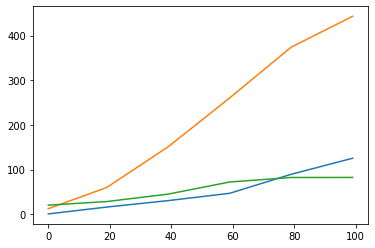

In [42]:
import matplotlib.pyplot as plt
import numpy as np

c = 5
d = np.repeat(np.random.normal(size=(1, 3, c)), 100, axis=0)
s = np.arange(c, dtype='float32') * 20
t = np.arange(100, dtype='float32')[:, None] + 1.

plt.plot(
    CallaborativeLinearTrendEmbedding.trend(
        d,
        np.arange(3) * 10,
        np.ones(3),
        s,
        t,
    ).numpy()
)

In [43]:
# import numpy as np
# import tensorflow as tf


# class SeasonalEmbedding(tf.keras.layers.Layer):
#     def __init__(self, *args, input_dim, period, N, **kwargs):
#         super().__init__(*args, **kwargs)
#         self.input_dim = input_dim
#         self.period = period
#         self.N = N
#         # model params
#         self.a_n, self.b_n = [tf.keras.layers.Embedding(input_dim=input_dim, output_dim=N, input_length=1)] * 2


#     def call(self, input_tensor, training=False):
#         id, t = input_tensor
#         n = (tf.range(self.N, dtype='float') + 1)[None, :]

#         instance_trend = self.fourier_series(
#             tf.squeeze(self.a_n(id), axis=1),
#             tf.squeeze(self.b_n(id), axis=1),
#             t,
#             n,
#             self.period)
#         global_trend = self.fourier_series(
#             tf.squeeze(self.a_n(tf.zeros_like(id)), axis=1),
#             tf.squeeze(self.b_n(tf.zeros_like(id)), axis=1),
#             t,
#             n,
#             self.period)
        
#         return instance_trend + global_trend

#     @staticmethod
#     def fourier_series(a_n, b_n, t, n, period):
#         x = (2 * np.pi * tf.multiply(t, n)) / period
#         return (
#             tf.reduce_sum(tf.multiply(tf.cos(x), a_n), axis=1, keepdims=True)
#             + tf.reduce_sum(tf.multiply(tf.sin(x), b_n), axis=1, keepdims=True)
#         )
    

# class SeasonalEmbeddingWithMovement(tf.keras.layers.Layer):
#     def __init__(self, *args, period, N, **kwargs):
#         super().__init__(*args, **kwargs)
#         self.period = period
#         self.N = N
#         # model params
#         self.a_n, self.b_n = [tf.keras.layers.Dense(self.N, activation='linear')] * 2

#     def call(self, input_tensor, training=False):
#         X, t = input_tensor
#         n = (tf.range(self.N, dtype='float') + 1)[None, :]

#         return self.fourier_series(
#             self.a_n(X),
#             self.b_n(X),
#             n,
#             self.period,
#             t)

#     @staticmethod
#     def fourier_series(a_n, b_n, n, period, t):
#         x = (2 * np.pi * tf.multiply(t, n)) / period
#         return (
#             tf.reduce_sum(tf.multiply(tf.cos(x), a_n), axis=1, keepdims=True)
#             + tf.reduce_sum(tf.multiply(tf.sin(x), b_n), axis=1, keepdims=True)
#         )


# class LinearTrendEmbedding(tf.keras.layers.Layer):
#     def __init__(self, *args, input_dim, max_t, n_changepoints=25, checkpoint_range=.8, **kwargs):
#         super().__init__(*args, **kwargs)
#         self.input_dim = input_dim
#         self.max_t = max_t
#         self.n_changepoints = n_changepoints
#         self.checkpoint_range = checkpoint_range
#         self.δ = tf.keras.layers.Embedding(input_dim=input_dim, output_dim=self.n_changepoints * 3, input_length=1,
#                                            # l1 imitates Laplace prior from Prophet model
#                                            embeddings_regularizer='l1')
#         self.m = tf.keras.layers.Embedding(input_dim=input_dim, output_dim=1, input_length=1)
#         self.k = tf.keras.layers.Embedding(input_dim=input_dim, output_dim=1, input_length=1)

#     def build(self, input_shape):
#         self.s = tf.cast(tf.linspace(0, int(self.checkpoint_range * self.max_t), self.n_changepoints + 1), 'float')[1:]

#     def call(self, input_tensor, training=False):
#         id, t = input_tensor
        
#         instance_trend = self.trend(
#             tf.reshape(tf.squeeze(self.δ(id), axis=1), (-1, self.n_changepoints, 3)),
#             tf.reshape(tf.squeeze(self.m(id), axis=1), (-1, self.n_changepoints, 3)),
#             tf.reshape(tf.squeeze(self.k(id), axis=1), (-1, self.n_changepoints, 3)),
#             self.s,
#             t)
        
#         global_trend = self.trend(
#             tf.reshape(tf.squeeze(self.δ(tf.zeros_like(id)), axis=1), (-1, self.n_changepoints, 3)),
#             tf.reshape(tf.squeeze(self.m(tf.zeros_like(id)), axis=1), (-1, self.n_changepoints, 3)),
#             tf.reshape(tf.squeeze(self.k(tf.zeros_like(id)), axis=1), (-1, self.n_changepoints, 3)),
#             self.s,
#             t)

#         return instance_trend + global_trend

#     @staticmethod
#     def trend(δ, m, k, s, t):
#         A = tf.cast((t > s), 'float')

#         trend = tf.reduce_sum(tf.multiply(A, δ), axis=-1) * t + k

#         γ = tf.multiply(-s, δ)
#         offset = tf.reduce_sum(tf.multiply(A, γ), axis=-1) + m

#         return trend + offset
    
    
# class LinearTrendEmbeddingWithMovement(tf.keras.layers.Layer):
#     def __init__(self, *args, t_range, n_changepoints=25, checkpoint_range=.8, **kwargs):
#         super().__init__(*args, **kwargs)
#         self.t_range = t_range
#         self.n_changepoints = n_changepoints
#         self.checkpoint_range = checkpoint_range
#         self.r = tf.keras.layers.Reshape((3, self.n_changepoints))
#         self.δ = tf.keras.layers.Dense(self.n_changepoints * 3, kernel_regularizer='l1')
#         self.m = tf.keras.layers.Dense(1)
#         self.k = tf.keras.layers.Dense(1)

#     def build(self, input_shape):
#         self.s = tf.cast(tf.linspace(self.t_range[0], int(self.checkpoint_range * self.t_range[1]), self.n_changepoints + 1), 'float')[1:]

#     def call(self, input_tensor, training=False):
#         X, t = input_tensor
#         return self.trend(
#             self.r(self.δ(X)),
#             self.m(X),
#             self.k(X),
#             self.s,
#             t)

#     @staticmethod
#     def trend(δ, m, k, s, t):
#         A = tf.cast((t > s), 'float')[:, None, :]

#         trend = (tf.reduce_sum(tf.multiply(A, δ), axis=-1) + k) * t

#         γ = tf.multiply(-s[None, None, :], δ)
#         offset = tf.reduce_sum(tf.multiply(A, γ), axis=-1) + m

#         return trend + offset
    

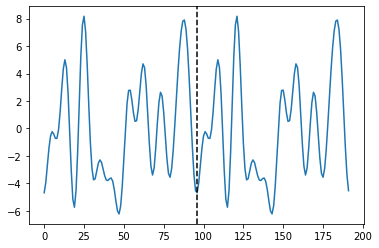

In [44]:
order = 10

plt.plot(
    CallaborativeSeasonalEmbedding.fourier_series(
        np.random.normal(size=order),
        np.random.normal(size=order),
        np.arange(order, dtype='float32') + 1,
        24,
        np.arange(192, dtype='float32')[:, None] / 4
    ).numpy().ravel()
)

plt.gca().axvline(96, ls='--', color='k')

# Model

In [281]:
import numpy as np
import tensorflow as tf
%run stl.py

pi = tf.constant(np.pi)
epsilon = tf.constant(1e-9)

ln = tf.math.log  # alias
lgamma = tf.math.lgamma  # alias


def nb_nll(z, model_outputs):
    μ, α = model_outputs[:, 0], model_outputs[:, 1]
    return -(
        lgamma(z + (1 / α)) - lgamma(z + 1) - lgamma(1 / α)
        - (1 / α) * ln(1 + α * μ)
        + z * ln(α * μ) -z * ln(1 + α * μ)
    )


def guassian_nll(z, model_outputs):
    mu, sigma = model_outputs[:, 0], model_outputs[:, 1]
    return tf.math.log(sigma + epsilon) + (((z - mu) ** 2) / (2 * sigma ** 2))


def scaler(inputs):
    mu, alpha, v = inputs[0], inputs[1], inputs[2]
    return tf.keras.layers.Concatenate()([mu * v, alpha / (2. * tf.sqrt(v))])
Scaler = tf.keras.layers.Lambda(scaler)

    
id_input = tf.keras.Input((1,), name='id')
t_input = tf.keras.Input((1,), name='t')


def STL(df, embedding_dim=10, trend_dim=1, n_inner_layers=2, n_outer_layers=2, n_changepoints=20,
        periods=None, T0=pd.Timestamp(0), output_activations=('linear',)):
    
    if periods is None:
        periods = [(1, 20), (7, 3), (365.25, 10)]
    
    T = (df.ds - T0).dt.total_seconds() / (3600 * 24)

    item_embeddings = tf.keras.layers.Reshape((embedding_dim,))(
        tf.keras.layers.Embedding(input_dim=df.id.nunique(), output_dim=embedding_dim, input_length=1)(id_input)
    )

    trend_embeddings = tf.keras.layers.BatchNormalization()(
       CallaborativeLinearTrendEmbedding(
           output_dim=trend_dim,  # maybe N, and feed to collaborative seasonal embeddings?
                                      # to get this to work we need to remove the linear growth assumption
                                      # e.g. maybe just multiply by one
                                  # or saturating growth might be sufficient
           input_dim=1,
           n_changepoints=n_changepoints,
           t_range=(T.min(), T.max())
       )([item_embeddings, t_input])
    )

    seasonal_embeddings = [
        CallaborativeSeasonalEmbedding(period=period, N=N, n_layers=n_inner_layers)([item_embeddings, t_input])
        for period, N in periods
    ]


    # perhaps a resnet layer would make sense here? If so maybe just use 4 instead
    # of `embedding_dim`
    X = tf.keras.layers.Concatenate()(seasonal_embeddings + [trend_embeddings])
    for i in range(n_outer_layers):
        X = tf.keras.layers.Dense(embedding_dim + trend_dim, activation='linear')(X)
        
#     X = tf.keras.layers.Concatenate()([
#         tf.keras.layers.Dense(1, activation=A)(X)
#         for A in output_activations
#     ])
            
    X =    tf.keras.layers.Dense(1, kernel_initializer='ones', trainable=False, activation='linear')(X)

    return X, seasonal_embeddings, trend_embeddings, item_embeddings


Z, seasonal_embeddings, trend_embeddings, item_embeddings = STL(
    df,
    embedding_dim=10,
    trend_dim=1,
    n_inner_layers=2,
    n_outer_layers=2,
    periods=[(7, 3), (365.25, 10)],
    n_changepoints=25,
    output_activations=['softplus'])

model = tf.keras.models.Model(
    inputs=[
        id_input,
        t_input,
    ],
    outputs=Z)
model.compile(loss='mse', optimizer='adam')


In [282]:
model.summary()

Model: "model_108"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
id (InputLayer)                 [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding_33 (Embedding)        (None, 1, 10)        10          id[0][0]                         
__________________________________________________________________________________________________
reshape_68 (Reshape)            (None, 10)           0           embedding_33[0][0]               
__________________________________________________________________________________________________
t (InputLayer)                  [(None, 1)]          0                                            
__________________________________________________________________________________________

In [283]:
df['births'] = df.births.astype('float')

In [284]:
model.fit(
    df[['id', 't']].to_dict('series'),
    df.births,
    batch_size=32,
    epochs=100,
)

Epoch 1/100
172/172 [==============================] - 1s 1ms/step - loss: 133538240.5549A: 0s - loss: 133507256.390
Epoch 2/100
172/172 [==============================] - 0s 1ms/step - loss: 133579191.7225
Epoch 3/100
172/172 [==============================] - 0s 1ms/step - loss: 131590352.2775
Epoch 4/100
172/172 [==============================] - 0s 1ms/step - loss: 124581497.7572
Epoch 5/100
172/172 [==============================] - 0s 1ms/step - loss: 119513303.3988
Epoch 6/100
172/172 [==============================] - 0s 1ms/step - loss: 113186430.4740
Epoch 7/100
172/172 [==============================] - 0s 1ms/step - loss: 104854828.1618
Epoch 8/100
172/172 [==============================] - 0s 1ms/step - loss: 94903713.5723
Epoch 9/100
172/172 [==============================] - 0s 1ms/step - loss: 82738267.2370
Epoch 10/100
172/172 [==============================] - 0s 1ms/step - loss: 70194408.7168
Epoch 11/100
172/172 [==============================] - 0s 1ms/step - loss:

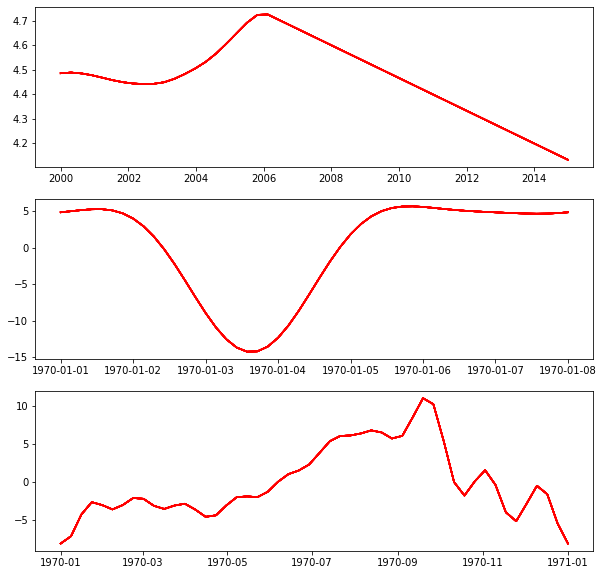

In [285]:
fig, axs = plt.subplots(1 + len(seasonal_embeddings), 1, figsize=(10, 10))

sampled_ids = np.random.choice(df.id.unique(), size=30)

trend_model = tf.keras.models.Model(inputs=[
        id_input,
        t_input,
    ], outputs=trend_embeddings)

for i in sampled_ids:
    T = np.linspace(df.t.min(), df.t.max())
    axs[0].plot(T0 + pd.to_timedelta(T, unit='days'),
                trend_model.predict({'t': T, 'id': np.zeros_like(T) + i}), color='r', alpha=.5)

for ax, E, P in zip(axs[1:], seasonal_embeddings, [7, 365.25]):
    T = np.linspace(0, P)
    seasonality_model = tf.keras.models.Model(inputs=[
        id_input,
        t_input,
    ], outputs=E)

    for i in sampled_ids:
        seasonal_embedding = seasonality_model.predict({'t': T, 'id': np.zeros_like(T) + i})
        ax.plot(T0 + pd.to_timedelta(T, unit='days'),
                seasonal_embedding, color='r', alpha=.5)


<AxesSubplot:>

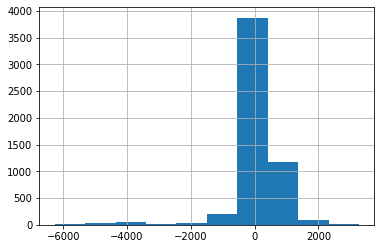

In [286]:
zz = df
y_test_params = model.predict(zz[['id', 't']].to_dict('series'))
mu = y_test_params[:, 0]

(zz.births - mu).hist()

<AxesSubplot:>

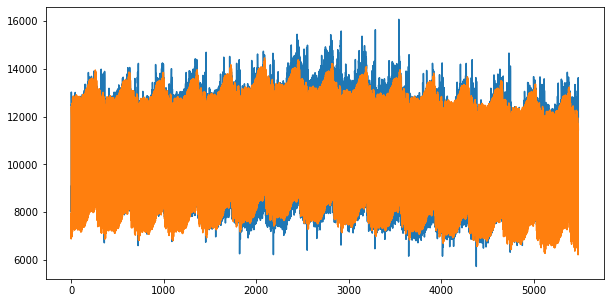

In [287]:
fig, ax = plt.subplots(figsize=(10, 5), sharey=True)


zz = df
zz['p'] = model.predict(zz[['id', 't']].to_dict('series'))[:, 0]
zz.births.plot(ax=ax, color='C0')
zz.p.plot(ax=ax, color='C1')


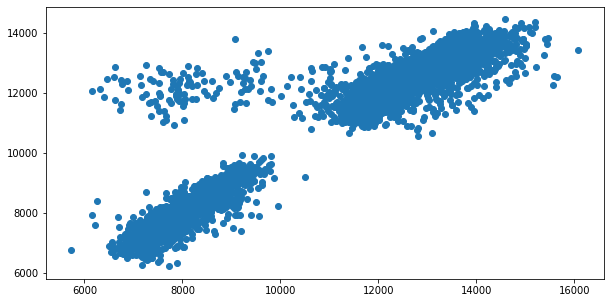

In [288]:
fig, ax = plt.subplots(figsize=(10, 5), sharey=True)


plt.scatter(zz.births, zz.p)
